# ML Nanodegree Capstone: NBA Fantasy Prediction

## Introduction to Problem
In the US, the National Basketball Association (NBA), is one of the four major sports. There are many stats recorded in a basketball game, both offensive an defensive. Further, many other metrics can be compounded from the recorded stats. For instance, points are recorded as well as minutes played, so we can investigate points per minute.

Additionally, fantasy sports, and more specifically, daily fantasy sports have become very popular as of late. In daily fantasy sports, a user selects about 8 basketball players that are playing that night. As many as hundreds of thousands of users pick a team on any given night. The entry fee to this daily tournament can range from 1 dollar to 100 dollars. Each player is rewarded a fantasy point value for stats recorded and the user that achieves the most fantasy points wins. In some tournaments, the users with the top 10% highest scores win some cash back.

Therefore, if I can predict how many fantasy points a player will score on a given night, it can be very lucrative, which is a regression problem. However, this prediction needs to be better than simple strategies such as the average fantasy points for each player. Another test could examine if a player will surpass his average for the season on a given night, this would be a classifier problem.

## How to go about Problem
The website basketball-reference.com has historical data for every NBA player going back for decades. For this project, I have downloaded the plast 3 years of gamelog data for each player. I downloaded full seasons 2013-14, 2014-15 and 2015-16, which comprise of 82 potential games for each player (sometimes there are injuries) and about 480 active players in the season. Therefore, there are about 82 x 480 = 39,360 potential gamelogs per season. However, given that there are injuries the number of actual gamelogs will be lower. Further, many players don't actually play in a given night or play very infrequently. These players are likely not important as they won't be selected in leagues. Therefore, for 3 seasons, my guess is that there are about 10,000 gamelogs per season that would be interesting to investigate.

Given this dataset, I would like to predict how many fantasy points a player achieves on a given night or if they surpass their season average, for games played in the 2016-17 season, which is the current season. The current season is only halfway complete to date. I have downloaded data through 26-Jan-2017, about 40 games. Therefore, I will train my models based on previous seasons and test the model on the current season.


In [1]:
#load the data
import numpy as np
import pandas as pd
import visuals as vs
from datetime import datetime
date_format="%Y-%m-%d %H:%M:%S"
date_format2="%Y-%m-%d"

%matplotlib inline

data_14_15=pd.read_csv('nba_14_15.csv')
data_16_17=pd.read_csv('nba_16_17.csv')

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
full_data=pd.concat([data_14_15, data_16_17])

In [3]:
len(full_data)

73965

In [4]:
full_data.head()

,player,game_date,age,player_team,location,opp_team,result,gs,mp,fg,...,ast,stl,blk,tov,pf,pts,game_score,plus_minus,fantasy,year_end
0,Quincy Acy,2014-10-29 00:00:00,24-023,NYK,H,CHI,L (-24),0,21:28,3,...,1,0,1,2,4,6,3.4,-15,16.00,2015
1,Quincy Acy,2014-10-30 00:00:00,24-024,NYK,A,CLE,W (+5),1,22:27,4,...,2,0,1,2,6,8,7.8,2,24.50,2015
2,Quincy Acy,2014-11-02 00:00:00,24-027,NYK,H,CHO,W (+3),1,20:20,1,...,2,0,0,0,2,2,1.1,11,8.75,2015
3,Quincy Acy,2014-11-05 00:00:00,24-030,NYK,A,DET,L (-3),0,13:42,0,...,1,0,1,2,1,0,0.9,-6,10.00,2015
4,Quincy Acy,2014-11-07 00:00:00,24-032,NYK,A,BRK,L (-11),0,22:14,3,...,0,0,0,3,3,7,3.8,-15,16.75,2015


In [5]:
print("the minimum year is: " + str(min(full_data['year_end'])))
print("the maximum year is: " + str(max(full_data['year_end'])))
print("the first game is: "+ str(min(full_data['game_date'])))
print("the last game is: "+ str(max(full_data['game_date'])))

the minimum year is: 2014
the maximum year is: 2017
the first game is: 2013-10-29 00:00:00
the last game is: 2017-01-27 00:00:00


In [6]:
train_data=full_data[full_data['year_end']<2017]
test_data=full_data[full_data['year_end']==2017]

In [7]:
sort_train=train_data.sort_values(by=['player','game_date'], axis=0, ascending=True)
sort_test=test_data.sort_values(by=['player','game_date'], axis=0, ascending=True)

## Adding the rolling data

Adding a rolling mean for the past 10 games and past 3 games to see if this data informs us of how well a player will play tonight.

In [8]:
def add_avg(dataset, stat, roll):
    dataset['avg'+str(roll)+stat]=dataset.groupby('player')[stat].rolling(window=roll).mean().shift(1).values

In [9]:
def add_opp(dataset, stat, roll):
    dataset['avg '+str(roll)+stat]=dataset.groupby('opp_team')[stat].rolling(window=roll).mean().shift(1).values

In [10]:
unique_players=full_data.player.unique()
unique_teams=full_data.opp_team.unique()

In [11]:
new_df=pd.DataFrame()
for i in range(0,len(unique_players)):
    player_df=sort_train[sort_train['player']==unique_players[i]]
    add_avg(player_df,"pts",10)
    add_avg(player_df, "fantasy",10)
    add_avg(player_df, "plus_minus",10)
    #add_avg(player_df, "ast",10)
    #add_avg(player_df, "trb",10)
    #add_avg(player_df, "stl",10)
    #add_avg(player_df, "blk",10)
    add_avg(player_df, "fgp",10)
    add_avg(player_df, "p3p",10)
    add_avg(player_df,"pts",3)
    add_avg(player_df, "fantasy",3)
    add_avg(player_df, "plus_minus",3)
    #add_avg(player_df, "ast",3)
    #add_avg(player_df, "trb",3)
    #add_avg(player_df, "stl",3)
    #add_avg(player_df, "blk",3)
    add_avg(player_df, "fgp",3)
    add_avg(player_df, "p3p",3)
    player_df['rest_days']=pd.to_datetime(player_df['game_date'],format=date_format).values-pd.to_datetime(player_df['game_date'],format=date_format).shift(1).values
    player_df['rest']=(player_df['rest_days'].dt.total_seconds() / (24 * 60 * 60)).values
    new_df=new_df.append(player_df)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

## Create data for the opposition fantasy

In [12]:
opp_data=pd.DataFrame({'opp_sum_fantasy':sort_train.groupby(['opp_team','game_date'])['fantasy'].sum()}).reset_index()

In [13]:
teams_df=pd.DataFrame()
for i in range(0,len(unique_teams)):
    team_df=opp_data[opp_data['opp_team']==unique_teams[i]]
    add_opp(team_df,'opp_sum_fantasy',10)
    teams_df=teams_df.append(team_df)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [14]:
final_data=pd.merge(new_df, teams_df, on=['opp_team', 'game_date'], how='left')

In [15]:
final_data.to_csv("nba_train.csv")

## Remove the stats

Now I will remove the stats from the game and just concentrate on the rolling averages going into the game, the game location and the fantasy points scored in the game.

In [16]:
features = final_data.drop(['player','game_date','age','player_team','opp_team','result',
                            'gs','mp','fg','fga','fgp','ft','fta','ftp','ast','orb','drb','trb',
                            'stl','blk','p3','p3a','p3p','pts','plus_minus',
                            'game_score','year_end','tov','pf','opp_sum_fantasy', 'rest_days'], axis=1)
features_clean=features.dropna()

## Let's examine the fantasy scores

It's important to understand the scale and distribution of the fantasy scores in a game. Further, we want to help predict players that are going to score a lot of points, while predicting that a player will not perform well can be helpful, we prefer to build a model to predict when a player will do well. Additionally, I am not too interested in players that don't score many fantasy points as having good accuracy there isn't beneficial.

In [17]:
print("max fantasy in a game: " + str(max(features_clean['fantasy'])))
print("min fantasy in a game: " + str(min(features_clean['fantasy'])))
print("average fantasy in a game: " + str(np.mean(features_clean['fantasy'])))
print("std dev fantasy in a game: "+str(np.std(features_clean['fantasy'])))
print("highest fantasy average over last 10 games: " + str(max(features_clean['avg10fantasy'])))
print("games above average: " + str(len(features_clean[features_clean['fantasy']>np.mean(features_clean['fantasy'])])))

max fantasy in a game: 93.5
min fantasy in a game: -1.5
average fantasy in a game: 22.4108284857
std dev fantasy in a game: 13.7691437676
highest fantasy average over last 10 games: 69.0
games above average: 25347


## Create a Fantasy and Features dataframe for all observations

In [18]:
fantasy = features_clean['fantasy']
features_final= features_clean.drop('fantasy',axis=1)

## Create a Fantasy and Features dataframe for the best scores

As mentioned earlier, I would like a model that predicts the fantasy scores far in the right tail of the distribution. If I can predict these scores accurately, then I can build a strong team that will outperform. Therefore, I am going the trim the dataset into a fantasy and feature one standard deviation from the mean as well as two standard deviations from the mean.

In [19]:
features_avg=features_clean[features_clean['fantasy']>np.mean(features_clean['fantasy'])]
fantasy_avg=features_avg['fantasy']
features_avg_final=features_avg.drop('fantasy', axis=1)

In [20]:
features_one_sd=features_clean[features_clean['fantasy']>np.mean(features_clean['fantasy'])+np.std(features_clean['fantasy'])]
fantasy_one_sd=features_one_sd['fantasy']
features_one_sd_final=features_one_sd.drop('fantasy', axis=1)

## Need to change the game location to numeric

In [21]:
features_final.replace(['H','A'],[1,0], inplace=True)
features_avg_final.replace(['H','A'],[1,0], inplace=True)
features_one_sd_final.replace(['H','A'],[1,0], inplace=True)

In [22]:
from sklearn.metrics import r2_score

def performance_metric_r2(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [23]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    features_final, fantasy, test_size=0.2, random_state=0)
X_train1, X_test1, y_train1, y_test1 = cross_validation.train_test_split(
    features_avg_final, fantasy_avg, test_size=0.2, random_state=0)
X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(
    features_one_sd_final, fantasy_one_sd, test_size=0.2, random_state=0)


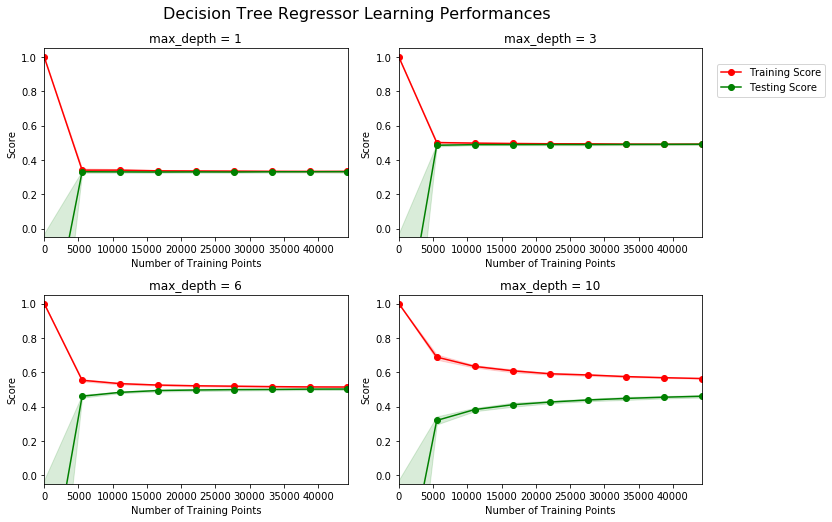

In [24]:
vs.ModelLearning(features_final, fantasy)

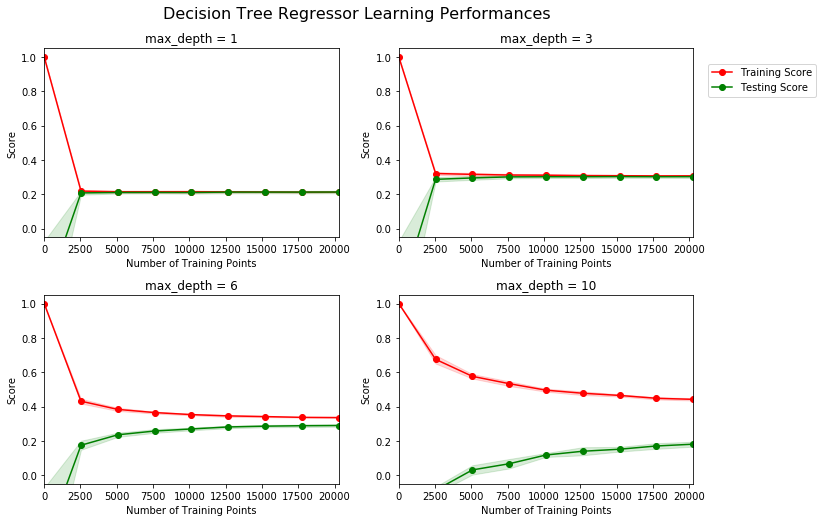

In [25]:
vs.ModelLearning(features_avg_final, fantasy_avg)

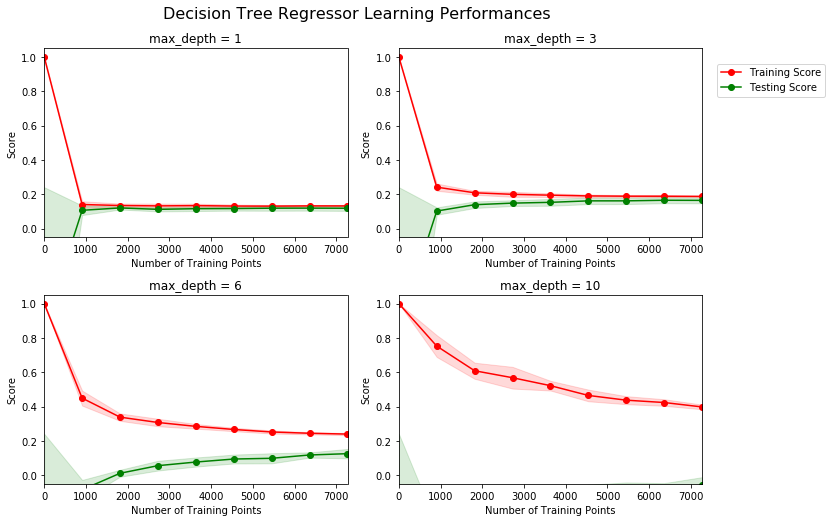

In [26]:
vs.ModelLearning(features_one_sd_final, fantasy_one_sd)

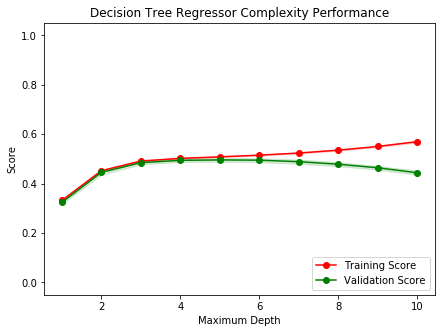

In [27]:
vs.ModelComplexity(X_train, y_train)

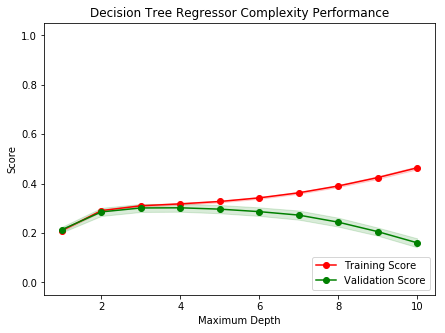

In [28]:
vs.ModelComplexity(X_train1, y_train1)

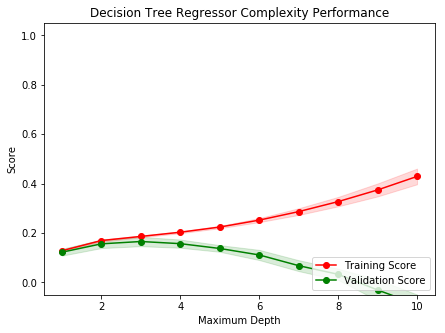

In [29]:
vs.ModelComplexity(X_train2, y_train2)

In [30]:
from sklearn.metrics import make_scorer
from sklearn.cross_validation import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm, grid_search
from time import time

def fit_Tree_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    start = time()
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    regressor = DecisionTreeRegressor(random_state=0)

    params = {'max_depth':range(1,11)}

    scoring_fnc = make_scorer(performance_metric_r2)

    grid = grid_search.GridSearchCV(regressor, params, cv=cv_sets, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    end=time()
    
    # Print the results
    print "Grid search took {:.4f} seconds".format(end - start)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

def fit_SVM_model(X, y):
    """ Performs grid search over the 'kernel' parameter for a 
        svm regressor trained on the input data [X, y]. """
    start=time()
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    regressor = svm.SVR()

    params = {'kernel':('linear','rbf')}

    scoring_fnc = make_scorer(performance_metric_r2)

    grid = grid_search.GridSearchCV(regressor, params, cv=cv_sets, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    end=time()
    
    # Print the results
    print "Grid search took {:.4f} seconds".format(end - start)


    # Return the optimal model after fitting the data
    return grid.best_estimator_

def fit_Boosting_model(X,y):
    """ Performs grid search over the 'max_depth', 'loss', 'learning_rate' and 'n_estimators' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    start=time()
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    regressor = GradientBoostingRegressor(random_state=0)

    params = {'max_depth':range(1,6), 'loss':('ls','quantile'), 'learning_rate':(0.1,0.5), 'n_estimators':(100,500)}

    scoring_fnc = make_scorer(performance_metric_r2)

    grid = grid_search.GridSearchCV(regressor, params, cv=cv_sets, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    end=time()
    
    # Print the results
    print "Grid search took {:.4f} seconds".format(end - start)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [31]:
reg = fit_Tree_model(X_train, y_train)
reg1 = fit_SVM_model(X_train, y_train)
reg2 = fit_Boosting_model(X_train, y_train)

# Produce the values for optimal parameters
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])
print "Parameter 'kernel' is {} for the optimal model.".format(reg1.get_params()['kernel'])
print "Parameter 'max_depth' is {} for the optimal model.".format(reg2.get_params()['max_depth'])

Grid search took 26.9566 seconds
Grid search took 14014.3949 seconds
Grid search took 5343.1935 seconds
Parameter 'max_depth' is 5 for the optimal model.
Parameter 'kernel' is linear for the optimal model.
Parameter 'max_depth' is 3 for the optimal model.


In [32]:
reg_avg = fit_Tree_model(X_train1, y_train1)
reg1_avg = fit_SVM_model(X_train1, y_train1)
reg2_avg = fit_Boosting_model(X_train1, y_train1)

# Produce the values for optimal parameters
print "Parameter 'max_depth' is {} for the optimal model.".format(reg_avg.get_params()['max_depth'])
print "Parameter 'kernel' is {} for the optimal model.".format(reg1_avg.get_params()['kernel'])
print "Parameter 'max_depth' is {} for the optimal model.".format(reg2_avg.get_params()['max_depth'])

Grid search took 13.0325 seconds
Grid search took 3101.7991 seconds
Grid search took 2417.4681 seconds
Parameter 'max_depth' is 4 for the optimal model.
Parameter 'kernel' is linear for the optimal model.
Parameter 'max_depth' is 2 for the optimal model.


In [33]:
reg_onesd = fit_Tree_model(X_train2, y_train2)
reg1_onesd = fit_SVM_model(X_train2, y_train2)
reg2_onesd = fit_Boosting_model(X_train2, y_train2)

# Produce the values for optimal parameters
print "Parameter 'max_depth' is {} for the optimal model.".format(reg_onesd.get_params()['max_depth'])
print "Parameter 'kernel' is {} for the optimal model.".format(reg1_onesd.get_params()['kernel'])
print "Parameter 'max_depth' is {} for the optimal model.".format(reg2_onesd.get_params()['max_depth'])

Grid search took 5.3211 seconds
Grid search took 522.5635 seconds
Grid search took 923.8573 seconds
Parameter 'max_depth' is 3 for the optimal model.
Parameter 'kernel' is linear for the optimal model.
Parameter 'max_depth' is 1 for the optimal model.


In [34]:
def train_regressor(clf, X_train, y_train):
    ''' Fits a regressor to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit regressor based on R2 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return r2_score(target.values, y_pred)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a regressor based on R2 score. '''
    
    # Indicate the regressor and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the regressor
    train_regressor(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "R2 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "R2 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

In [35]:
reg_A = svm.SVR(kernel=reg1.get_params()['kernel'])
reg_B = GradientBoostingRegressor(random_state=0, max_depth=reg2.get_params()['max_depth'])
reg_C = DecisionTreeRegressor(random_state=0, max_depth=reg.get_params()['max_depth'])

for reg in [reg_A, reg_B, reg_C]:
    train_predict(reg,X_train, y_train, X_test, y_test)

Training a SVR using a training set size of 44283. . .
Trained model in 1479.9172 seconds
Made predictions in 67.4424 seconds.
R2 score for training set: 0.5044.
Made predictions in 16.5666 seconds.
R2 score for test set: 0.5122.
Training a GradientBoostingRegressor using a training set size of 44283. . .
Trained model in 6.0646 seconds
Made predictions in 0.1323 seconds.
R2 score for training set: 0.5222.
Made predictions in 0.0346 seconds.
R2 score for test set: 0.5173.
Training a DecisionTreeRegressor using a training set size of 44283. . .
Trained model in 0.2117 seconds
Made predictions in 0.0095 seconds.
R2 score for training set: 0.5066.
Made predictions in 0.0027 seconds.
R2 score for test set: 0.5067.


In [36]:
reg_A_1 = svm.SVR(kernel=reg1_avg.get_params()['kernel'])
reg_B_1 = GradientBoostingRegressor(random_state=0, max_depth=reg2_avg.get_params()['max_depth'])
reg_C_1 = DecisionTreeRegressor(random_state=0, max_depth=reg_avg.get_params()['max_depth'])


for reg in [reg_A_1, reg_B_1, reg_C_1]:
    train_predict(reg,X_train1, y_train1, X_test1, y_test1)

Training a SVR using a training set size of 20277. . .
Trained model in 383.9208 seconds
Made predictions in 11.0532 seconds.
R2 score for training set: 0.2898.
Made predictions in 2.8799 seconds.
R2 score for test set: 0.2732.
Training a GradientBoostingRegressor using a training set size of 20277. . .
Trained model in 1.5191 seconds
Made predictions in 0.0444 seconds.
R2 score for training set: 0.3313.
Made predictions in 0.0108 seconds.
R2 score for test set: 0.3064.
Training a DecisionTreeRegressor using a training set size of 20277. . .
Trained model in 0.0789 seconds
Made predictions in 0.0043 seconds.
R2 score for training set: 0.3165.
Made predictions in 0.0010 seconds.
R2 score for test set: 0.2974.


In [37]:
reg_A_2 = svm.SVR(kernel=reg1_onesd.get_params()['kernel'])
reg_B_2 = GradientBoostingRegressor(random_state=0, max_depth=reg2_onesd.get_params()['max_depth'])
reg_C_2 = DecisionTreeRegressor(random_state=0, max_depth=reg_onesd.get_params()['max_depth'])


for reg in [reg_A_2, reg_B_2, reg_C_2]:
    train_predict(reg,X_train2, y_train2, X_test2, y_test2)

Training a SVR using a training set size of 7267. . .
Trained model in 60.7601 seconds
Made predictions in 1.4081 seconds.
R2 score for training set: 0.1262.
Made predictions in 0.3470 seconds.
R2 score for test set: 0.1230.
Training a GradientBoostingRegressor using a training set size of 7267. . .
Trained model in 0.3050 seconds
Made predictions in 0.0100 seconds.
R2 score for training set: 0.1928.
Made predictions in 0.0026 seconds.
R2 score for test set: 0.1873.
Training a DecisionTreeRegressor using a training set size of 7267. . .
Trained model in 0.0237 seconds
Made predictions in 0.0015 seconds.
R2 score for training set: 0.1859.
Made predictions in 0.0005 seconds.
R2 score for test set: 0.1804.


## Using our models, predict values in 2017

Now that we have three models, one trained on all players, one trained on players that scored fantasy points above the mean and one trained on players that scored one standard deviation above the mean. Therefore, we can test these models out of sample and see how they fare in predicting fantasy scores from 2017.

In [38]:
new_test_df=pd.DataFrame()
for i in range(0,len(unique_players)):
    player_df=sort_test[sort_test['player']==unique_players[i]]
    add_avg(player_df,"pts",10)
    add_avg(player_df, "fantasy",10)
    add_avg(player_df, "plus_minus",10)
    #add_avg(player_df, "ast",10)
    #add_avg(player_df, "trb",10)
    #add_avg(player_df, "stl",10)
    #add_avg(player_df, "blk",10)
    add_avg(player_df, "fgp",10)
    add_avg(player_df, "p3p",10)
    add_avg(player_df,"pts",3)
    add_avg(player_df, "fantasy",3)
    add_avg(player_df, "plus_minus",3)
    #add_avg(player_df, "ast",3)
    #add_avg(player_df, "trb",3)
    #add_avg(player_df, "stl",3)
    #add_avg(player_df, "blk",3)
    add_avg(player_df, "fgp",3)
    add_avg(player_df, "p3p",3)
    player_df['rest_days']=pd.to_datetime(player_df['game_date'],format=date_format).values-pd.to_datetime(player_df['game_date'],format=date_format).shift(1).values
    player_df['rest']=(player_df['rest_days'].dt.total_seconds() / (24 * 60 * 60)).values
    new_test_df=new_test_df.append(player_df)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

In [39]:
opp_test_data=pd.DataFrame({'opp_sum_fantasy':sort_test.groupby(['opp_team','game_date'])['fantasy'].sum()}).reset_index()
teams_test_df=pd.DataFrame()
for i in range(0,len(unique_teams)):
    team_df=opp_test_data[opp_test_data['opp_team']==unique_teams[i]]
    add_opp(team_df,'opp_sum_fantasy',10)
    teams_test_df=teams_test_df.append(team_df)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [40]:
final_test_data=pd.merge(new_test_df, teams_test_df, on=['opp_team','game_date'], how='left')

In [41]:
test_features = final_test_data.drop(['player','game_date','age','player_team','opp_team','result',
                            'gs','mp','fg','fga','fgp','ft','fta','ftp','ast','orb','drb','trb',
                            'stl','blk','p3','p3a','p3p','pts','plus_minus',
                            'game_score','year_end','tov','pf', 'opp_sum_fantasy', 'rest_days'], axis=1)
test_features=test_features.dropna()

In [42]:
test_fantasy = test_features['fantasy']
test_features = test_features.drop('fantasy',axis=1)

In [43]:
test_features.replace(['H','A'],[1,0], inplace=True)

## The model that did best is the Boosting regression so let's review the models trained on all data and then the Boosting regression for each set of training data

In [44]:
preds1=reg.predict(test_features)
preds2=reg1.predict(test_features)
preds3=reg2.predict(test_features)
preds4=reg2_avg.predict(test_features)
preds5=reg2_onesd.predict(test_features)

In [45]:
print("The R2 for the first regression: " + str(reg.score(test_features, test_fantasy)))
print("The R2 for the second regression: " + str(reg1.score(test_features, test_fantasy)))
print("The R2 for the third regression: " + str(reg2.score(test_features, test_fantasy)))
print("The R2 for the fourth regression: " + str(reg2_avg.score(test_features, test_fantasy)))
print("The R2 for the fifth regression: " + str(reg2_onesd.score(test_features, test_fantasy)))

The R2 for the first regression: -2.06763017498
The R2 for the second regression: 0.579969684985
The R2 for the third regression: 0.574823936141
The R2 for the fourth regression: -0.153631155731
The R2 for the fifth regression: -2.057051024


In [46]:
from sklearn.metrics import mean_squared_error

print("The MSE for the first regression: " + str(mean_squared_error(preds1, test_fantasy)))
print("The MSE for the second regression: " + str(mean_squared_error(preds2, test_fantasy)))
print("The MSE for the third regression: " + str(mean_squared_error(preds3, test_fantasy)))
print("The MSE for the fourth regression: " + str(mean_squared_error(preds4, test_fantasy)))
print("The MSE for the fifth regression: " + str(mean_squared_error(preds5, test_fantasy)))

The MSE for the first regression: 614.035378199
The MSE for the second regression: 84.0758039997
The MSE for the third regression: 85.1058081583
The MSE for the fourth regression: 230.917777765
The MSE for the fifth regression: 611.917791462


## To see if the regressions are useful, let's compare to a naive prediction of the 10 and 3 game average fantasy scores

In [47]:
print("The MSE for the first regression: " + str(mean_squared_error(preds1, test_fantasy)))
print("The MSE for all players, using past 10 game fantasy average: " + str(mean_squared_error(test_features['avg10fantasy'], test_fantasy)))
print("The MSE for all players, using the past 3 game fantasy average: " + str(mean_squared_error(test_features['avg3fantasy'], test_fantasy)))

print("\n")

print("The MSE for the second regression: " + str(mean_squared_error(preds2, test_fantasy)))
print("The MSE for one sd players, using past 10 game fantasy average: " + str(mean_squared_error(test_features['avg10fantasy'], test_fantasy)))
print("The MSE for one sd players, using the past 3 game fantasy average: " + str(mean_squared_error(test_features['avg3fantasy'], test_fantasy)))

print("\n")

print("The MSE for the third regression: " + str(mean_squared_error(preds3, test_fantasy)))
print("The MSE for two sd players, using past 10 game fantasy average: " + str(mean_squared_error(test_features['avg10fantasy'], test_fantasy)))
print("The MSE for two sd players, using the past 3 game fantasy average: " + str(mean_squared_error(test_features['avg3fantasy'], test_fantasy)))

print("\n")

print("The MSE for the fourth regression: " + str(mean_squared_error(preds4, test_fantasy)))
print("The MSE for two sd players, using past 10 game fantasy average: " + str(mean_squared_error(test_features['avg10fantasy'], test_fantasy)))
print("The MSE for two sd players, using the past 3 game fantasy average: " + str(mean_squared_error(test_features['avg3fantasy'], test_fantasy)))

print("\n")

print("The MSE for the fifth regression: " + str(mean_squared_error(preds5, test_fantasy)))
print("The MSE for two sd players, using past 10 game fantasy average: " + str(mean_squared_error(test_features['avg10fantasy'], test_fantasy)))
print("The MSE for two sd players, using the past 3 game fantasy average: " + str(mean_squared_error(test_features['avg3fantasy'], test_fantasy)))


The MSE for the first regression: 614.035378199
The MSE for all players, using past 10 game fantasy average: 85.6348922538
The MSE for all players, using the past 3 game fantasy average: 100.002532058


The MSE for the second regression: 84.0758039997
The MSE for one sd players, using past 10 game fantasy average: 85.6348922538
The MSE for one sd players, using the past 3 game fantasy average: 100.002532058


The MSE for the third regression: 85.1058081583
The MSE for two sd players, using past 10 game fantasy average: 85.6348922538
The MSE for two sd players, using the past 3 game fantasy average: 100.002532058


The MSE for the fourth regression: 230.917777765
The MSE for two sd players, using past 10 game fantasy average: 85.6348922538
The MSE for two sd players, using the past 3 game fantasy average: 100.002532058


The MSE for the fifth regression: 611.917791462
The MSE for two sd players, using past 10 game fantasy average: 85.6348922538
The MSE for two sd players, using the past

In [48]:
print(reg1.coef_)
print(reg1_avg.coef_)
print(reg1_onesd.coef_)

print("\n")

print(reg2.feature_importances_)
print(reg2_avg.feature_importances_)
print(reg2_onesd.feature_importances_)

[[ 0.57722254  0.07907048  0.74297441 -0.01462792 -5.85330663 -2.47539999
   0.03375591  0.18738441 -0.03056555  1.20163206 -0.37770525 -0.01362714
   0.01935567]]
[[  4.96651747e-01   5.42821878e-02   4.46808607e-01   2.90375110e-02
   -7.29662449e+00  -3.37788328e+00   1.89088465e-02   6.29479278e-02
   -9.24927017e-03  -4.89902807e-01  -1.00416590e+00  -4.01979149e-03
    1.92978095e-02]]
[[  5.36248139e-02   5.67899967e-02   2.49825738e-01   3.02942786e-02
   -4.16239804e+00  -1.64536294e+00  -1.23777009e-03   1.73369646e-02
   -1.85088531e-02  -1.87632497e-01   1.49378519e-01  -2.01852180e-03
    7.08370952e-03]]


[ 0.02100478  0.06910873  0.24741373  0.06316417  0.08322556  0.04904447
  0.06333891  0.15726699  0.05203521  0.04003238  0.0220663   0.05678112
  0.07551765]
[ 0.02681009  0.05161994  0.32379358  0.06000719  0.04852771  0.07714145
  0.02960567  0.13058756  0.04837245  0.07249107  0.02894692  0.03390971
  0.06818667]
[ 0.    0.04  0.46  0.05  0.01  0.08  0.08  0.12  0.

In [49]:
def player_reg(player_name, train_data, test_data):
    player_data=train_data[train_data['player']==player_name]
    player_features=player_data.drop(['player','game_date','age','player_team','opp_team','result',
                            'gs','mp','fg','fga','fgp','ft','fta','ftp','ast','orb','drb','trb',
                            'stl','blk','p3','p3a','p3p','pts','plus_minus',
                            'game_score','year_end','tov','pf', 'opp_sum_fantasy', 'rest_days'], axis=1)
    player_features.dropna(inplace=True)
    player_fantasy=player_features['fantasy']
    player_features.drop('fantasy',axis=1,inplace=True)
    player_features.replace(['H','A'],[1,0], inplace=True)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    player_features, player_fantasy, test_size=0.2, random_state=0)
    
    player1=fit_Tree_model(X_train, y_train)
    player2=fit_SVM_model(X_train, y_train)
    player3=fit_Boosting_model(X_train, y_train)

    reg_A = DecisionTreeRegressor(random_state=0, max_depth=player1.get_params()['max_depth'])
    reg_B = svm.SVR(kernel=player2.get_params()['kernel'])
    reg_C = GradientBoostingRegressor(random_state=0,max_depth=player3.get_params()['max_depth'], loss=player3.get_params()['loss'], learning_rate=player3.get_params()['learning_rate'], n_estimators=player3.get_params()['n_estimators'])
    for reg in [reg_A, reg_B, reg_C]:
        train_predict(reg,X_train, y_train, X_test, y_test)
    
    player_data_test=test_data[test_data['player']==player_name]
    player_features_test=player_data_test.drop(['player','game_date','age','player_team','opp_team','result',
                            'gs','mp','fg','fga','fgp','ft','fta','ftp','ast','orb','drb','trb',
                            'stl','blk','p3','p3a','p3p','pts','plus_minus',
                            'game_score','year_end','tov','pf', 'opp_sum_fantasy', 'rest_days'], axis=1)
    player_features_test.dropna(inplace=True)
    player_fantasy_test=player_features_test['fantasy']
    player_features_test.drop('fantasy',axis=1, inplace=True)
    player_features_test.replace(['H','A'],[1,0], inplace=True)
    preds1=player1.predict(player_features_test)
    preds2=player2.predict(player_features_test)
    preds3=player3.predict(player_features_test)
    
    print("The MSE for the first regression: " + str(mean_squared_error(preds1, player_fantasy_test)))
    print("The MSE for the second regression: " + str(mean_squared_error(preds2, player_fantasy_test)))
    print("The MSE for the third regression: " + str(mean_squared_error(preds3, player_fantasy_test)))
    print("The MSE for all players, using past 10 game fantasy average: " + str(mean_squared_error(player_features_test['avg10fantasy'], player_fantasy_test)))
    print("The MSE for all players, using the past 3 game fantasy average: " + str(mean_squared_error(player_features_test['avg3fantasy'], player_fantasy_test)))
    ten_game_mse=mean_squared_error(player_features_test['avg10fantasy'], player_fantasy_test)
    three_game_mse=mean_squared_error(player_features_test['avg3fantasy'], player_fantasy_test)
    
    best_mse=0
    for player in [player1, player2, player3]:
        mse = mean_squared_error(player.predict(player_features_test), player_fantasy_test)
        if best_mse==0:
            best_mse=mse
            model=player
        else:
            if mse < best_mse:
                best_mse=mse
                model=player
    return_dict={player_name:{'best regression':model, 'best mse':best_mse, 'avg 10 mse':ten_game_mse, 'avg 3 mse':three_game_mse}}
    return return_dict

In [50]:
top_200=[]
for i in sort_train.player.unique():
    top_200.append([str(i), np.mean(sort_train[sort_train['player']==i]['fantasy'])])

top_200_fantasy=sorted(top_200, key=lambda x: (x[1]), reverse=True)

cnt=1
top_20_final=[]
for i in top_200_fantasy:
    if cnt < 21:
        top_20_final.append(i)
    cnt += 1

In [51]:
player_dict={}
for i in top_20_final:
    player_dict.update(player_reg(i[0], final_data, final_test_data))

Grid search took 1.4946 seconds
Grid search took 0.8223 seconds
Grid search took 79.9990 seconds
Training a DecisionTreeRegressor using a training set size of 144. . .
Trained model in 0.0011 seconds
Made predictions in 0.0003 seconds.
R2 score for training set: 0.3007.
Made predictions in 0.0003 seconds.
R2 score for test set: -0.2566.
Training a SVR using a training set size of 144. . .
Trained model in 0.0045 seconds
Made predictions in 0.0018 seconds.
R2 score for training set: 0.1073.
Made predictions in 0.0006 seconds.
R2 score for test set: -0.0623.
Training a GradientBoostingRegressor using a training set size of 144. . .
Trained model in 0.0370 seconds
Made predictions in 0.0006 seconds.
R2 score for training set: 0.4175.
Made predictions in 0.0004 seconds.
R2 score for test set: -0.2057.
The MSE for the first regression: 186.504627676
The MSE for the second regression: 277.13554711
The MSE for the third regression: 169.380621737
The MSE for all players, using past 10 game fan

In [52]:
total_fantasy=0
for i in top_20_final:
    total_fantasy += i[1]

In [53]:
reg_mse=0
avg10_mse=0
for i in top_20_final:
    reg_mse += player_dict[i[0]]['best mse']*i[1]/total_fantasy
    avg10_mse += player_dict[i[0]]['avg 10 mse']*i[1]/total_fantasy

In [54]:
reg_mse

134.54788168345661

In [55]:
avg10_mse

138.69382527605725

In [56]:
sum(player_dict[key]['best mse'] for key, value in player_dict.items())/20

133.20067476046992

In [57]:
sum(player_dict[key]['avg 10 mse'] for key, value in player_dict.items())/20

137.273510930691